# Plotting utilities

`xarrayutils` provides a bunch of small functions to adjust [matplotlib](https://matplotlib.org) plots.

## Setting multiple y axes to the same values range
Sometimes it is beneficial if the amplitude of a signal can be compared directly. If the mean of the signal is shifted, setting the absolute y limits doesnt work. `same_y_range` provides a quick fix.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

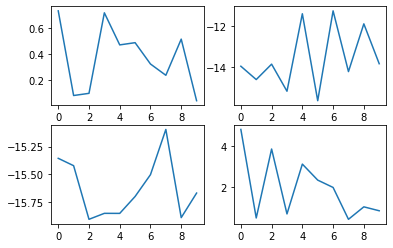

In [2]:
fig, axarr = plt.subplots(ncols=2, nrows=2)

# plot the same signal scaled and shifted or both
axarr.flat[0].plot(np.random.rand(10))
axarr.flat[1].plot((np.random.rand(10)*5)-16)
axarr.flat[2].plot((np.random.rand(10))-16)
axarr.flat[3].plot((np.random.rand(10)*5))


These are hard to compare with regard to their amplitude. 

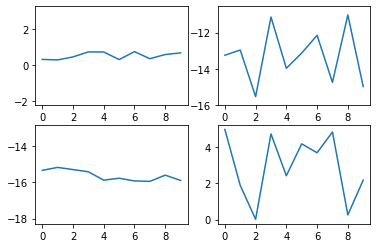

In [3]:
from xarrayutils.plotting import same_y_range

fig, axarr = plt.subplots(ncols=2, nrows=2)

# plot the same signal scaled and shifted or both
axarr.flat[0].plot(np.random.rand(10))
axarr.flat[1].plot((np.random.rand(10)*5)-16)
axarr.flat[2].plot((np.random.rand(10))-16)
axarr.flat[3].plot((np.random.rand(10)*5))

same_y_range(axarr)

Now we can clearly see the different amplitude. 